<a href="https://colab.research.google.com/github/NadjaKljestanovic/PPPO/blob/main/DetekcijaObjekata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install gdown

In [4]:
import gdown
import os
import sys
import random
import math
import warnings
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd
import glob
import numpy as np
import pandas as pd
from skimage.io import imread
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable()

In [5]:
!git clone https://github.com/maxw1489/Mask_RCNN.git
os.chdir('Mask_RCNN')

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 31 (delta 6), reused 20 (delta 0), pack-reused 0
Receiving objects: 100% (31/31), 10.81 MiB | 29.52 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [6]:
sys.path.append(os.path.join('Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [7]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

-rw-r--r-- 1 root root 246M Dec  6  2021 mask_rcnn_coco.h5


In [8]:
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

In [9]:
data_dir = '/content/drive/MyDrive/data'

In [10]:
main_dir = '/content/drive/MyDrive'

In [11]:
train_dir = os.path.join(data_dir, 'training_images')

In [12]:
test_dir = os.path.join(data_dir, 'testing_images')

In [13]:
import os

train_images = os.listdir(train_dir)
num_train_images = len(train_images)

test_images = os.listdir(test_dir)
num_test_images = len(test_images)

In [14]:
print("Količina slika za trening:", num_train_images)

Količina slika za trening: 1001


In [15]:
print("Korličina slika za test:", num_test_images)

Korličina slika za test: 175


In [16]:
import pandas as pd
import os

In [17]:
csv_test = os.path.join(data_dir, 'sample_submission.csv')

In [18]:
csv_train = os.path.join(data_dir, 'train_solution_bounding_boxes (1).csv')

In [19]:
dataTestCsv = pd.read_csv(csv_test)
dataTrainCsv = pd.read_csv(csv_train)

In [20]:
print("\nCsv test fajl:")
print(dataTestCsv)

print("\nCsv trening fajl:")
print(dataTrainCsv)


Csv test fajl:
              image                           bounds
0   vid_5_26560.jpg  0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0
1   vid_5_26580.jpg  0.0 0.0 1.0 1.0 0.0 0.0 1.0 1.0
2   vid_5_26600.jpg                  0.0 0.0 1.0 1.0
3   vid_5_26620.jpg                  0.0 0.0 1.0 1.0
4   vid_5_26640.jpg                  0.0 0.0 1.0 1.0
..              ...                              ...
78  vid_5_31560.jpg                  0.0 0.0 1.0 1.0
79  vid_5_31600.jpg                  0.0 0.0 1.0 1.0
80  vid_5_31620.jpg                  0.0 0.0 1.0 1.0
81  vid_5_31700.jpg                  0.0 0.0 1.0 1.0
82  vid_5_31720.jpg                  0.0 0.0 1.0 1.0

[83 rows x 2 columns]

Csv trening fajl:
               image        xmin        ymin        xmax        ymax
0     vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1    vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2    vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3    vid_4_10020.jpg  496.4833

In [21]:
import pandas as pd

In [22]:
csv_train = os.path.join(data_dir, 'train_solution_bounding_boxes (1).csv')
df_train = pd.read_csv(csv_train)

In [23]:
class_counts1 = df_train['xmin'].notnull().value_counts()

In [24]:
print("Raspodela klasa - xmin:")
print(class_counts1)

Raspodela klasa - xmin:
True    559
Name: xmin, dtype: int64


In [25]:
class_counts2 = df_train['xmax'].notnull().value_counts()

In [26]:
print("Raspodela klasa - xmax:")
print(class_counts2)

Raspodela klasa - xmax:
True    559
Name: xmax, dtype: int64


**Spajanje u jednu kolonu BOUNDS - moze se obrisati**

In [27]:
import pandas as pd

In [28]:
# Load your CSV file into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv')

In [29]:
# Create a new column 'bounds' by merging xmin, xmax, ymin, ymax with space separation
df['bounds'] = df[['xmin', 'xmax', 'ymin', 'ymax']].astype(str).agg(' '.join, axis=1)

In [30]:
# Optionally, you can drop the individual columns if you no longer need them
df = df.drop(['xmin', 'xmax', 'ymin', 'ymax'], axis=1)


In [31]:
print(df)

               image                                           bounds
0     vid_4_1000.jpg   281.2590449 327.7279305 187.0350708 223.225547
1    vid_4_10000.jpg  15.16353111 120.3299566 187.0350708 236.4301802
2    vid_4_10040.jpg  239.1924747 361.9681621 176.7648005 236.4301802
3    vid_4_10020.jpg  496.4833575 630.0202605 172.3632561 231.5395753
4    vid_4_10060.jpg  16.63096961 132.5586107 186.5460103 238.3864221
..               ...                                              ...
554   vid_4_9860.jpg          0.0 49.23525127 198.3217293 236.2232837
555   vid_4_9880.jpg   329.8761835 536.6642389 156.482351 250.4978951
556   vid_4_9900.jpg          0.0 141.7975237 168.2958225 239.1766516
557   vid_4_9960.jpg   487.4289876 616.9176985 172.2336464 228.839864
558   vid_4_9980.jpg   221.5586307 348.585579 182.5704339 238.1921956

[559 rows x 2 columns]


**Razdvajanje jedne kolone u XMIN, XMAX, YMIN, YMAX**

In [32]:
import pandas as pd

In [33]:
# Load your CSV file into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')

*brisanje prva dva reda*

In [34]:
# Drop the first two rows
df = df.drop([0, 1])  # Replace 0 and 1 with the actual indices of the rows you want to delete

# Reset the index after dropping rows
df = df.reset_index(drop=True)

In [35]:
# Split the 'bounds' column into separate columns
df[['xmin', 'xmax', 'ymin', 'ymax']] = df['bounds'].str.split(expand=True)

In [36]:
# Convert the new columns to numeric (if needed)
df[['xmin', 'xmax', 'ymin', 'ymax']] = df[['xmin', 'xmax', 'ymin', 'ymax']].apply(pd.to_numeric)

In [37]:
# Optionally, you can drop the original 'bounds' column if you no longer need it
df = df.drop(['bounds'], axis=1)

In [38]:
print(df)

              image  xmin  xmax  ymin  ymax
0   vid_5_26600.jpg   0.0   0.0   1.0   1.0
1   vid_5_26620.jpg   0.0   0.0   1.0   1.0
2   vid_5_26640.jpg   0.0   0.0   1.0   1.0
3   vid_5_26660.jpg   0.0   0.0   1.0   1.0
4   vid_5_26680.jpg   0.0   0.0   1.0   1.0
..              ...   ...   ...   ...   ...
76  vid_5_31560.jpg   0.0   0.0   1.0   1.0
77  vid_5_31600.jpg   0.0   0.0   1.0   1.0
78  vid_5_31620.jpg   0.0   0.0   1.0   1.0
79  vid_5_31700.jpg   0.0   0.0   1.0   1.0
80  vid_5_31720.jpg   0.0   0.0   1.0   1.0

[81 rows x 5 columns]


**Učitavanje slike i crtanje pravougaonika**

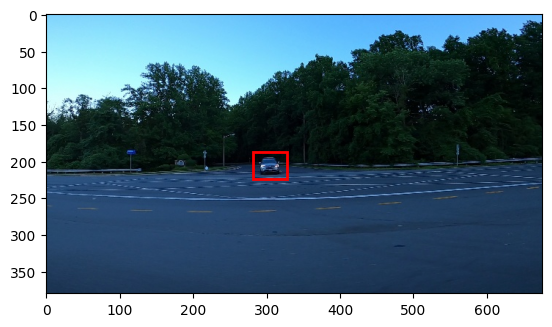

In [39]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load the image
image_path = '/content/drive/MyDrive/data/training_images/vid_4_1000.jpg'  # Replace with the path to your image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a figure and axes
fig, ax = plt.subplots(1)

# Display the image before drawing the bounding box
ax.imshow(image_rgb)

# Define bounding box coordinates (xmin, ymin, width, height)
bbox_before = [281.2590449,187.0350708,327.7279305-281.2590449,223.225547-187.0350708]

# Create a Rectangle patch
rect_before = patches.Rectangle((bbox_before[0], bbox_before[1]), bbox_before[2], bbox_before[3], linewidth=2, edgecolor='r', facecolor='none')

# Add the rectangle to the Axes
ax.add_patch(rect_before)

# Show the image with the bounding box
plt.show()

**Kraj**

In [40]:
debug = False

In [41]:
def file_names(directory):
  file_names = []
  with os.scandir(directory) as entries:
          for entry in entries:
                file_names.append(entry.name)
  return file_names

In [42]:
train_names = file_names(train_dir)
test_names = file_names(test_dir)

In [43]:
print(len(train_names))

1001


In [44]:
print(len(test_names))

175


In [45]:
df = pd.DataFrame({'File Name': train_names})

In [46]:
df.to_csv('/content/drive/MyDrive/data/train_names.csv', index=False)


In [47]:
df = pd.DataFrame({'File Name': test_names})

In [48]:
df.to_csv('/content/drive/MyDrive/data/test_names.csv', index=False)

In [49]:
df = pd.read_csv('/content/drive/MyDrive/data/train_names.csv')

In [50]:
train_names1 = df['File Name']

In [51]:
df = pd.read_csv('/content/drive/MyDrive/data/test_names.csv')

In [52]:
test_names1 = df['File Name']

In [53]:
image_folder = '/content/drive/MyDrive/data/training_images'

In [54]:
csv_file = '/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv'

In [55]:
image_names = [os.path.splitext(filename)[0] + '.jpg' for filename in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, filename))]

In [56]:
data = pd.read_csv(csv_file)

In [57]:
filtered_data = data[data['image'].isin(image_names)]

In [58]:
filtered_data.to_csv('/content/drive/MyDrive/data/train_solution_bounding_boxes_v2.csv',index=False)

In [59]:
annotations = pd.read_csv('/content/drive/MyDrive/data/train_solution_bounding_boxes_v2.csv')

In [60]:
annotations.shape

(559, 5)

In [61]:
im_names, image_annotations = train_names1, annotations

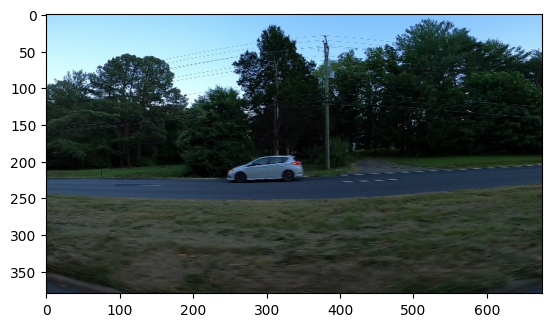

In [62]:
ds = imread(os.path.join(train_dir, im_names[0]))
_ = plt.imshow(ds)

In [63]:
ORIG_SIZE = 768

Da li se ORIG_SIZE moze obrisati?

In [64]:
class ModelConfig(Config):
    NAME = 'BoundingBoxDetection'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    BACKBONE = 'resnet50'

    NUM_CLASSES = 1 + 1  # Background + Your Number of Classes

    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # Adjust anchor scales based on your dataset
    TRAIN_ROIS_PER_IMAGE = 128
    MAX_GT_INSTANCES = 100
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 200
    DETECTION_MIN_CONFIDENCE = 0.7  # Adjust based on your requirements
    DETECTION_NMS_THRESHOLD = 0.3  # Adjust based on your requirements
    RUN_EAGERLY = False

    STEPS_PER_EPOCH = 15 if debug else 5
    VALIDATION_STEPS = 10 if debug else 3

    LOSS_WEIGHTS = {
        "rpn_class_loss": 1.0,
        "rpn_bbox_loss": 1.0,
        "mrcnn_class_loss": 1.0,
        "mrcnn_bbox_loss": 1.0
    }

config = ModelConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_I

In [66]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import torch
import random
from torchvision.ops import nms
import cv2
import PIL.Image as Image
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

image_size=256
batch_size=4
device='cuda' if torch.cuda.is_available() else 'cpu'
epochs=40
lr=0.0002

# File Paths
dir_path = '/content/drive/MyDrive/data'
csv_file = '/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv'

In [67]:
df = pd.read_csv(csv_file)
df['label']=[1]*len(df)

print(f"Dataframe containing {len(df)} total targets for {len(df.image.unique())} Images \n")
df

Dataframe containing 559 total targets for 355 Images 



,image,xmin,ymin,xmax,ymax,label
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,1
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,1
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180,1
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575,1
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422,1
...,...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284,1
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895,1
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652,1
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864,1


In [68]:
from sklearn.model_selection import train_test_split
train_img_ids, val_img_ids = train_test_split(df.image.unique(),test_size=0.1,random_state=32)

train_df = df[df.image.isin(train_img_ids)]
val_df = df[df.image.isin(val_img_ids)]

In [77]:
import torch
import albumentations as A


# Augs
train_augs=A.Compose([
    A.Resize(image_size,image_size),
    A.HorizontalFlip(p=0.2),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=False)

val_augs=A.Compose([
    A.Resize(image_size,image_size),
],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']), is_check_shapes=False)

test_augs=A.Compose([
    A.Resize(image_size,image_size)
],is_check_shapes=False)


# Torch Dataset
class CarDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, image_ids, df, augs=None, train=True):
        self.df=df
        self.augs=augs
        self.image_ids=image_ids
        if train:
            self.dir_path='/content/drive/MyDrive/data/training_images'
        else:
            self.dir_path='/content/drive/MyDrive/data/testing_images'

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self,idx):
        image_id=self.image_ids[idx]
        image_path=os.path.join(self.dir_path,image_id)
        image=cv2.imread(image_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        bboxes = self.df[self.df.image==image_id][['xmin','ymin','xmax','ymax']].values
        labels = self.df[self.df.image==image_id][['label']].values

        if self.augs!=None:
            data=self.augs(image=image, bboxes=bboxes, class_labels=['None']*len(bboxes))
            image=data['image']
            bboxes=data['bboxes']

        image = torch.Tensor(np.transpose(image,(2,0,1)))/255.0
        bboxes = torch.Tensor(bboxes).long()
        labels = torch.Tensor(labels).long().squeeze(1)

        target={}
        target['boxes']=bboxes
        target['labels']=labels

        return image, target

    def collate_fn(self,batch):
        return tuple(zip(*batch))


# Instance
trainset=CarDetectionDataset(train_img_ids, train_df, augs=train_augs)
valset=CarDetectionDataset(val_img_ids, val_df,augs=val_augs)

print(f"{len(trainset)} Training Images containing {len(train_df)} bboxes \n")

319 Training Images containing 491 bboxes 



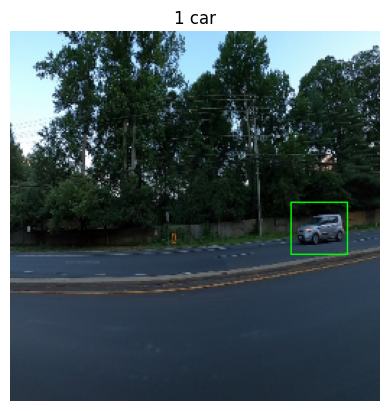

In [78]:
idx=random.randint(0,len(trainset)-1)

image, target = trainset[idx]
bbox, label = target['boxes'], target['labels']
image = image.permute(1,2,0).numpy()

for i in range(len(bbox)):
    sp=(int((bbox[i][0]).item()),int((bbox[i][1]).item()))
    ep=(int((bbox[i][2]).item()),int((bbox[i][3]).item()))
    c = (0,255,0)
    image = cv2.rectangle(image, sp, ep, c, 1)

plt.imshow(image)
plt.axis('off')
plt.title(str(len(bbox))+' car')
plt.show()

In [79]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, collate_fn=trainset.collate_fn ,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, collate_fn=valset.collate_fn)

print(f"Number of Batches: {len(trainloader)}")

Number of Batches: 80


In [80]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(preTrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,2)
model.to(device);

In [81]:
import torchvision
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model_ssd = torchvision.models.detection.ssd300_vgg16(preTrained=True, num_classes=2)
model_ssd.to(device);

In [82]:
from tqdm.auto import tqdm

def trainarc(model, dataloader, opt):
    model.train()
    train_loss=0.0

    for image, target in tqdm(dataloader):
        image = list(i.to(device) for i in image)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]

        opt.zero_grad()
        losses = model(image, target)
        loss = sum(loss for loss in losses.values())
        loss.backward()
        opt.step()

        train_loss+=loss.item()

    return train_loss/len(dataloader)

In [85]:
best_train_loss = np.Inf
opt = torch.optim.Adam(model_ssd.parameters(), lr=lr)

# Set the number of epochs to 2
epochs = 2

for i in range(epochs):
    train_loss = trainarc(model_ssd, trainloader, opt)

    print(f"Epoch: {i+1}:- TrainLoss: {train_loss}")

    if train_loss < best_train_loss:
        torch.save(model_ssd.state_dict(), '/content/drive/MyDrive/data/model_ssd.pt')
        print("Model Updated")
        best_train_loss = train_loss

print(f"DONE.\nTrainLoss: {best_train_loss}")

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1:- TrainLoss: 3.6026913583278657
Model Updated


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 2:- TrainLoss: 3.5245795130729674
Model Updated
DONE.
TrainLoss: 3.5245795130729674


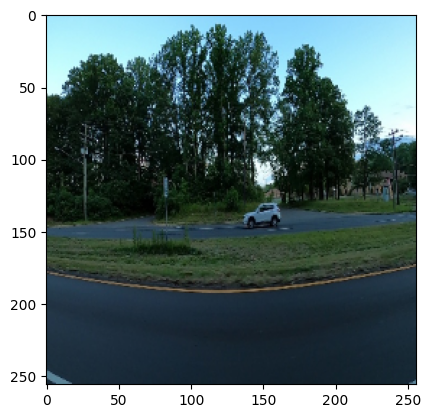

In [86]:
model_ssd.load_state_dict(torch.load('/content/drive/MyDrive/data/model_ssd.pt'))
idx=random.randint(1,len(valset)-1)
image, target = valset[20]
image = image.permute(1,2,0).numpy()
image = test_augs(image=image)['image']

plt.imshow(image)

In [87]:
img = torch.Tensor(np.transpose(image,(2,0,1)))

model_ssd.eval()
pred = model_ssd([img.to(device)])
pred

[{'boxes': tensor([[136.4611, 127.7364, 163.3026, 150.7214],
          [217.3722, 221.4802, 256.0000, 256.0000],
          [ 98.8500,   0.0000, 158.7554,  42.4698],
          [153.4633,   0.0000, 213.3688,  42.4698],
          [  0.0000,  52.8476,  49.5288,  97.0831],
          [ 57.8900, 162.0743, 117.7954, 206.3098],
          [126.1567,  66.5010, 186.0621, 110.7364],
          [ 98.8500,  93.8076, 158.7554, 138.0431],
          [126.1567,  93.8076, 186.0621, 138.0431],
          [ 16.9300,   0.0000,  76.8354,  42.4698],
          [126.1567,   0.0000, 186.0621,  42.4698],
          [  0.0000, 121.1143,  49.5288, 165.3497],
          [180.7700, 121.1143, 240.6754, 165.3497],
          [ 85.1967, 162.0743, 145.1021, 206.3098],
          [208.0767, 121.1143, 256.0000, 165.3497],
          [ 44.2367,  11.8876, 104.1421,  56.1231],
          [167.1167,  52.8476, 227.0221,  97.0831],
          [ 44.2367,  93.8076, 104.1421, 138.0431],
          [  0.0000, 162.0743,  49.5288, 206.3098],
   

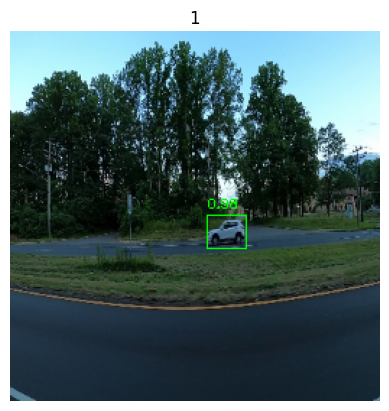

In [93]:
image = img.permute(1,2,0).detach().cpu().numpy().copy()
bbox = pred[0]['boxes'].detach().cpu().numpy()
score = pred[0]['scores'].detach().cpu().numpy()

score_threshold = np.where(pred[0]['scores'].detach().cpu().numpy()>0.4)[0]
ixs = nms(torch.Tensor(bbox),torch.Tensor(score),0.05)
filt = np.intersect1d(ixs, score_threshold)

bbox = bbox[filt]
score = score[filt]

for i in range(len(bbox)):
    sp=(int((bbox[i][0]).item()),int((bbox[i][1]).item()))
    ep=(int((bbox[i][2]).item()),int((bbox[i][3]).item()))
    cv2.rectangle(image, sp, ep, (0,255,0), 1)
    cv2.putText(image, str(score[i])[:4], (sp[0], sp[1]-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,255,0), 1)

plt.imshow(image)
plt.axis('off')
plt.title(str(len(filt)))
plt.show()